# Извлечение данных 

In [1]:
import pandas as pd

In [3]:
file_name = "../data/ПП 2024 27.08.2024.xlsx"
dfs = pd.read_excel(file_name, sheet_name=None)


In [4]:
dfs_pp_original = dfs["ПП"] 
dfs_potrebnosti_original = dfs["Потребности"] 

In [5]:
header_pp = dfs_pp_original.columns.tolist()
headers_potreb = dfs_potrebnosti_original.columns.tolist()

# Создание таблицы предложений ПП+Потребности

In [5]:
from openpyxl import load_workbook
from openpyxl import Workbook

def create_table(file_name):
    wb = Workbook()
    ws = wb.active
    wb.save(file_name)
    
def creat_headers( dfs_pp, dfs_potreb, file_name):
    header_pp = dfs_pp.columns.tolist()
    headers_potreb = dfs_potreb.columns.tolist()
    # Заголовки, которые нужно добавить
    headers = header_pp+headers_potreb+["Схожесть"]
    # Загрузка существующего файла Excel
    wb = load_workbook(file_name)
    ws = wb.active

    # Вставка заголовков в первую строку
    ws.insert_rows(1)  # Вставляем новую первую строку для заголовков
    for col_num, header in enumerate(headers, 1):
        ws.cell(row=1, column=col_num, value=header)

    # Сохранение изменений в файл
    wb.save(file_name)
    
def create_result_table(dfs_pp, dfs_potrebnosti, file_name = "match_table.xlsx"):
    create_table(file_name=file_name)
    creat_headers(dfs_pp, dfs_potrebnosti, file_name=file_name)

# Препроцессинг данных 

In [1]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Загрузка стоп-слов и других ресурсов NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Функция для замены знаков препинания пробелами
def remove_punctuation(text):
    if isinstance(text, str):  # Проверяем, что text это строка
        return re.sub(r'[^\w\s]', ' ', text)  # Заменяем все символы, кроме букв, цифр и пробелов, на пробелы
    return text

# Функция для приведения текста к нижнему регистру
def to_lowercase(text):
    if isinstance(text, str):  # Проверяем, что text это строка
        return text.lower()
    return text

# Функция для удаления цифр
def remove_numbers(text):
    if isinstance(text, str):  # Проверяем, что text это строка
        return re.sub(r'\d+', '', text)
    return text


# Функция для удаления стоп-слов (предлогов, союзов и т.д.)
def remove_stopwords(text):
    if isinstance(text, str):  # Проверяем, что text это строка
        stop_words = set(stopwords.words('russian'))  # Можно использовать 'english' для английского текста
        words = nltk.word_tokenize(text)
        return ' '.join([word for word in words if word not in stop_words])
    return text

# Функция для стемминга
stemmer = SnowballStemmer("russian")

def stem_text(text):
    if isinstance(text, str):  # Проверяем, что text это строка
        words = nltk.word_tokenize(text)
        return ' '.join([stemmer.stem(word) for word in words])
    return text

def remove_nan_rows(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Столбец {column_name} не найден в DataFrame")
    # Удалить строки с NaN в указанном столбце
    df_cleaned = df.dropna(subset=[column_name])
    return df_cleaned



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wormsin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wormsin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/wormsin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
def clean_text_column(df, column, oper):
    if oper[5] == 1:
        df = remove_nan_rows(df, column)
    if oper[0] == 1:
        df[column] = df[column].apply(remove_punctuation)
    if oper[1] == 1:
        df[column] = df[column].apply(to_lowercase)
    if oper[2] == 1:
        df[column] = df[column].apply(remove_numbers)
    if oper[3] == 1:
        df[column] = df[column].apply(stem_text)
    if oper[4] == 1:
        df[column] = df[column].apply(remove_stopwords)
    return df

In [3]:
list_of_strings = ["remove_punctuation", "to_lowercase", "remove_numbers", "stem_text", "remove_stopwords", "remove_nan_rows"]
dict_from_list = {i: s for i, s in enumerate(list_of_strings)}
dict_from_list


{0: 'remove_punctuation',
 1: 'to_lowercase',
 2: 'remove_numbers',
 3: 'stem_text',
 4: 'remove_stopwords',
 5: 'remove_nan_rows'}

In [4]:
def data_preprocess(dfs_pp = dfs_pp_original.copy(), dfs_potrebnosti = dfs_potrebnosti_original.copy()):
    #ПП
    dfs_pp = clean_text_column(dfs_pp, "Потребитель", [1, 1, 0, 0, 0, 1])
    dfs_pp = clean_text_column(dfs_pp, "Отдел", [1, 1, 0, 0, 0, 0])
    #dfs_pp =clean_text_column(dfs_pp, "Материал, применение", [1, 1, 1, 1, 1, 0])
    dfs_pp =clean_text_column(dfs_pp, "Материал, применение", [1, 1, 0, 1, 1, 0])
    dfs_pp =clean_text_column(dfs_pp, "Товар", [1, 1, 0, 0, 1, 0])

    #Потребности
    dfs_potrebnosti = clean_text_column(dfs_potrebnosti, "Потребитель", [1, 1, 0, 0, 0, 1])
    dfs_potrebnosti = clean_text_column(dfs_potrebnosti, "Отдел", [1, 1, 0, 0, 0, 0])
    #dfs_potrebnosti = clean_text_column(dfs_potrebnosti, "Материал", [1, 1, 1, 1, 1, 0])
    dfs_potrebnosti = clean_text_column(dfs_potrebnosti, "Материал", [1, 1, 0, 1, 1, 0])
    
    return dfs_pp, dfs_potrebnosti 

NameError: name 'dfs_pp_original' is not defined

In [5]:
def data_preprocess_pivot(dfs):
    dfs =clean_text_column(dfs, "Материал ПП", [1, 1, 0, 1, 1, 0])
    dfs =clean_text_column(dfs, "Товар", [1, 1, 0, 0, 1, 0])
    
    dfs = clean_text_column(dfs, "Материал потребитель", [1, 1, 0, 1, 1, 0])
    return dfs
    
def data_preprocess_pivot_dops(dfs):
    dfs =clean_text_column(dfs, "Установка", [1, 1, 0, 0, 0, 0])
    dfs =clean_text_column(dfs, "Производитель", [1, 1, 0, 0, 0, 0])
    
    dfs = clean_text_column(dfs, "Примечание", [1, 1, 0, 1, 1, 0])
    return dfs
    

In [10]:
def data_preprocess_dops(dfs_pp, dfs_potrebnosti):
    #ПП
    dfs_pp =clean_text_column(dfs_pp, "Установка", [1, 1, 0, 0, 0, 0])
    dfs_pp =clean_text_column(dfs_pp, "Производитель", [1, 1, 0, 0, 0, 0])
    
    #Потребности
    #dfs_potrebnosti = clean_text_column(dfs_potrebnosti, "Примечание", [1, 1, 1, 1, 1, 0])
    dfs_potrebnosti = clean_text_column(dfs_potrebnosti, "Примечание", [1, 1, 0, 1, 1, 0])
    
    return dfs_pp, dfs_potrebnosti

In [ ]:
dfs_pp, dfs_pp_potrebnosti = data_preprocess()

# Алгортмы сравнения строк 

## сохранение мэтчей

In [11]:
from openpyxl.utils.dataframe import dataframe_to_rows

def save_to_xlsx(i, pp_otdel_potreb, indx_res, resalt, file_name = "match_table.xlsx"):
    wb = load_workbook(file_name)
    ws = wb.active
    pp_values = pp_otdel_potreb.loc[i].to_list()
    #df_pp = pd.DataFrame([pp_values])
    
    if len(indx_res)!=0:
        s_values = resalt.loc[indx_res[0]].to_list()
        df_pp = pd.DataFrame([pp_values+s_values])
        for r in dataframe_to_rows(df_pp, index=False, header=None):
                ws.append(r)
        if len(indx_res)!=1:
            for j in indx_res[1:]:
                s_values = resalt.loc[j].to_list()
                df_s = pd.DataFrame([[''] * len(pp_values) + s_values])
                #df = pd.concat([df_pp, df_s], ignore_index=True)
                for r in dataframe_to_rows(df_s, index=False, header=None):
                    ws.append(r)
            max_row = ws.max_row
            # Merge cells for p_values and g_values
            for j in range(1, len(pp_values)+1):  
                ws.merge_cells(start_row=max_row-len(indx_res)+1, start_column=j, end_row=max_row, end_column=j)
    else:
        col = ws.max_column
        df = pd.DataFrame([pp_values+['']*(col-len(pp_values))])
        for r in dataframe_to_rows(df, index=False, header=None):
                ws.append(r)
                
    # Save the workbook
    wb.save(file_name)
    
def save_to_txt(i, pp_otdel_potreb, resalt):
    print("Строка из ПП\n")
    print(pp_otdel_potreb.loc[i].to_frame().T.to_markdown())
    print("\nСоответствующие строки из Потребностей\n")
    print(resalt.to_markdown())

## rapidfuzz

rapidfuzz.process.extract : Find the best matches in a list of choices. The list is sorted by the similarity. When multiple choices have the same similarity, they are sorted by their index; 

In [35]:
from rapidfuzz import process, fuzz, utils
import numpy as np

scorers = [fuzz.WRatio,fuzz.token_set_ratio]
scorer = scorers[0]

def param_sort_rf(param, table, column_name, original_table = None, threshold=50, similarity=False):
    potrebnosti_s = ""
    potrebnosti_s = table[column_name].tolist()
    potrebnosti_s = [' '.join(np.array(potrebnosti_s).astype(str))]
    #for s in column_name:
    #    potrebnosti_s+=table[s]
    sort1 = process.extract(param, potrebnosti_s, scorer=scorer, score_cutoff=threshold, limit=None)
    indx1 = [i[2] for i in sort1]
    if similarity:
        sim = [i[1] for i in sort1]
        new = original_table.loc[indx1]
        new["схожесть"] = sim
        return new, indx1
    return table.loc[indx1], indx1


## jaccard

In [25]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelBinarizer


# множество состоит из слов 
def jaccard_similarity(str1, str2):
    # Разбиваем строки на множества слов (или символов)
    set1 = set(str1.split())
    set2 = set(str2.split())
    print(set1, set2)
    # Объединяем все слова для векторизации
    union = set1.union(set2)
    
    # Векторизуем строки
    lb = LabelBinarizer()
    lb.fit(list(union))
    
    vec1 = lb.transform(list(set1)).sum(axis=0)
    vec2 = lb.transform(list(set2)).sum(axis=0)
    
    # Вычисляем метрику Джаккарда
    return jaccard_score(vec1, vec2, average='binary')
    

In [26]:
# множество из букв

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def word_similarity(word1, word2):
    set1 = set(word1)
    set2 = set(word2)
    return jaccard_similarity(set1, set2)

def overall_similarity_total(str1, str2):
    words1 = str1.split()
    words2 = str2.split()
    
    total_similarity = 0
    count_comparisons = 0
    
    for word1 in words1:
        for word2 in words2:
            total_similarity += word_similarity(word1, word2)
            count_comparisons += 1
    
    return (total_similarity / count_comparisons) * 100 if count_comparisons != 0 else 0

def overall_similarity_best(str1, str2):
    words1 = str1.split()
    words2 = str2.split()
    
    max_similarities = []
    
    for word1 in words1:
        max_similarity = 0
        for word2 in words2:
            similarity = word_similarity(word1, word2)
            if similarity > max_similarity:
                max_similarity = similarity
        max_similarities.append(max_similarity)
    
    average_similarity = sum(max_similarities) / len(max_similarities) if max_similarities else 0
    
    return average_similarity * 100  # Преобразуем в процентное значение

In [27]:
def param_sort_j(param, table, column_names,original_table = None, threshold=50, similarity=False):
    matches = []
    indxs = []
    #for idx, row in table.iterrows():
        #current_string = ""
        #for s in column_names:
        #    current_string+=str(row[s])
    current_string = table[column_names].tolist()
    current_string = ' '.join(np.array(current_string).astype(str))
    metric = overall_similarity_best(param, current_string)
    idx = 0 
    if abs(metric) > threshold:
        matches.append(metric)
        indxs.append(idx)
    if similarity:
        new = original_table.loc[idx]
        new["схожесть"] = metric
        return new, indxs
    return table.loc[indxs], indxs

## vectorization 

In [73]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np 

model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

def param_sort_ce(param, table, column_name, original_table = None,threshold=50, similarity=False):
    potrebnosti_s = ""
    #for s in column_name:
    #    potrebnosti_s+=table[s]
    potrebnosti_s = table[column_name].tolist()
    potrebnosti_s = [' '.join(np.array(potrebnosti_s).astype(str))]
    if len(potrebnosti_s) > 0:
        #indx_oigin = np.array(potrebnosti_s.index.tolist())
        indx_oigin = [0]
        #sort1 = model.rank(param, list(map(str, potrebnosti_s.tolist())))
        sort1 = model.rank(param, potrebnosti_s)
        indx_l= np.array([i['corpus_id'] for i in sort1])
        if similarity:
            sim = np.array([i['score'] for i in sort1])*100
            indx_l = indx_l[sim>threshold]
            sim = sim[sim>threshold]
            #indx1 = indx_oigin[indx_l]
            indx1 = 0
            new = original_table.loc[indx1]
            new["схожесть"] = sim
            return new, indx1
        else:
            indx1 = indx_oigin[indx1].tolist()
    else:
        indx1 = []
    return table.loc[indx1], indx1

/home/wormsin/miniconda3/envs/file_clean/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def param_sort_st(param, table, column_name,original_table = None, threshold=50, similarity=False):
    potrebnosti_s = ""
    #for s in column_name:
    #    potrebnosti_s+=table[s]
    potrebnosti_s = table[column_name].tolist()
    potrebnosti_s = [' '.join(np.array(potrebnosti_s).astype(str))]
    if len(potrebnosti_s)>0:
        # Compute embeddings for both lists
        embeddings1 = model.encode(param)
        #embeddings2 = model.encode(list(map(str, potrebnosti_s.tolist())))
        embeddings2 = model.encode(potrebnosti_s)
        # Compute cosine similarities
        sort1 = model.similarity(embeddings1, embeddings2)
        #indx1 = np.array(table.index.tolist())
        sort1 = np.array(sort1[0])*100
        #indx1 = indx1[sort1>threshold]
        indx1 = 0
        if similarity:
            sim = sort1[abs(sort1)>=threshold]
            new = original_table.loc[indx1]
            new["схожесть"] = abs(sim[0])
            return new, indx1
    else:
        indx1 = []
    return table.loc[indx1], indx1

In [30]:
import fasttext
import fasttext.util
import numpy as np
from scipy.spatial.distance import cosine

model  = fasttext.util.download_model('ru', if_exists='ignore')
model = fasttext.load_model(model)

def get_embedding(text):
    return model.get_sentence_vector(text)

def cosine_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)


def param_sort_ft(param, table, column_names,original_table = None, threshold=50, similarity=False):
    matches = []
    indxs = []
    
    for idx, row in table.iterrows():
        current_string = ""
        for s in column_names:
            current_string+=str(row[s])
        embedding1 = get_embedding(current_string)
        embedding2 = get_embedding(param)
        metric = cosine_similarity(embedding1, embedding2)*100
        
        if metric > threshold:
            matches.append(metric)
            indxs.append(idx)
    if similarity:
        new = original_table.loc[indxs]
        new["схожесть"] = matches
        return new, indxs
    return table.loc[indxs], indxs

KeyboardInterrupt: 

## Создание сводной таблицы 

In [150]:
def match_rows(dfs_pp, dfs_potrebnosti, original_dfs, param_sort, 
               columns4match_pp = ["Товар", "Материал, применение"], columns4match_potrebnosti = ["Материал"], 
               thresh = 50, file_name = "match_table.xlsx", smart_dops = False):
    columns4match_pp_default = ["Товар", "Материал, применение"]
    columns4match_potrebnosti_default = ["Материал"]
    #список уникальных потребителей
    p_potreb = dfs_pp["Потребитель"].drop_duplicates().to_list()
    while len(p_potreb)>0:
        param1 = p_potreb.pop(0) #потребитель из ПП
        print(f"\nПотребитель:{param1}\n")
        p_otdels = dfs_pp[dfs_pp["Потребитель"]==param1]["Отдел"].drop_duplicates().to_list() #список отделов для потребителя 
        sort_potrebnosti_param1, _ = param_sort_rf(param1, dfs_potrebnosti, ["Потребитель"], threshold=90)
        print(p_otdels)
        while len(p_otdels)>0 and sort_potrebnosti_param1.shape[0]>0:
            param2 = p_otdels.pop(0) #отдел
            print(f"\nОтдел:{param2}\n")
            sort_potrebnosti_param2, _ = param_sort_rf(param2, sort_potrebnosti_param1, ["Отдел"], threshold=90)
            
            pp_potreb =dfs_pp[dfs_pp["Потребитель"]==param1]
            pp_otdel_potreb = pp_potreb[pp_potreb["Отдел"]==param2]
            param3 = pp_otdel_potreb.index.to_list() #строки пп для мэтча
            for i in param3:
                pp_ref = ''
                for c in columns4match_pp:
                    pp_ref += str(pp_otdel_potreb.loc[i][c])
                
                resalt, indx_res = param_sort(pp_ref, sort_potrebnosti_param2, columns4match_potrebnosti, 
                                              original_table = original_dfs,  threshold=thresh, similarity=True)
                if len(indx_res) == 0 and smart_dops:
                    pp_ref = ''
                    for c in columns4match_pp_default:
                        pp_ref += str(pp_otdel_potreb.loc[i][c])
                    resalt, indx_res = param_sort(pp_ref, sort_potrebnosti_param2, columns4match_potrebnosti_default, 
                                              original_table = original_dfs,  threshold=thresh, similarity=True)
                    
                #save_to_txt(i, pp_otdel_potreb, resalt)
                save_to_xlsx(i, dfs_pp_original, indx_res, resalt, file_name=file_name)

## Примеры

In [48]:
file_name = "result_tables/match_table_rapidfuzz3.xlsx"
columns4match_pp = ["Товар", "Материал, применение", "Производитель", "Установка"]
columns4match_potrebnosti = ["Материал", "Примечание"]

In [49]:
## создание результирующей таблицы
create_result_table(dfs_pp_original, dfs_potrebnosti_original, file_name=file_name)

In [ ]:
# обработка данных
dfs_pp, dfs_potrebnosti = data_preprocess()
dfs_pp, dfs_potrebnosti = data_preprocess_dops(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti)

In [ ]:
## rapid fuzz
match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_rf, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name)

In [ ]:
## jaccard
match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_j, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name)

In [ ]:
## FastText
match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_ft, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name)

In [ ]:
## Cross Encoder 
match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_ce, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name)

In [ ]:
## Sentence transformer   
match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_st, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name)

## Exp
without dops, with dops, mix\
с числовыми данными и без\
method_numbers_dops.xlsx

#### RapidFuzz

In [ ]:
# очищать от числовых данных
file_name = "result_tables/rf_1_mix.xlsx"
#columns4match_pp = ["Товар", "Материал, применение"]
#columns4match_potrebnosti = ["Материал"]
columns4match_pp = ["Товар", "Материал, применение", "Установка", "Производитель"]
columns4match_potrebnosti = ["Материал", "Примечание"]

## создание результирующей таблицы
create_result_table(dfs_pp_original, dfs_potrebnosti_original, file_name=file_name)

# обработка данных
dfs_pp, dfs_potrebnosti = data_preprocess()
dfs_pp, dfs_potrebnosti = data_preprocess_dops(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti)

## rapid fuzz
match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_rf, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name, smart_dops=True)


### Jaccard

In [ ]:
# очищать от числовых данных
file_name = "result_tables/j_0_mix.xlsx"
#columns4match_pp = ["Товар", "Материал, применение"]
#columns4match_potrebnosti = ["Материал"]
columns4match_pp = ["Товар", "Материал, применение", "Установка", "Производитель"]
columns4match_potrebnosti = ["Материал", "Примечание"]

## создание результирующей таблицы
create_result_table(dfs_pp_original, dfs_potrebnosti_original, file_name=file_name)

# обработка данных
dfs_pp, dfs_potrebnosti = data_preprocess()
dfs_pp, dfs_potrebnosti = data_preprocess_dops(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti)

match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_j, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name, smart_dops=True)

### Language models

In [ ]:
# очищать от числовых данных
file_name = "result_tables/ce_1_0.xlsx"
columns4match_pp = ["Товар", "Материал, применение"]
columns4match_potrebnosti = ["Материал"]
#columns4match_pp = ["Товар", "Материал, применение", "Установка", "Производитель"]
#columns4match_potrebnosti = ["Материал", "Примечание"]

## создание результирующей таблицы
create_result_table(dfs_pp_original, dfs_potrebnosti_original, file_name=file_name)

# обработка данных
dfs_pp, dfs_potrebnosti = data_preprocess()
dfs_pp, dfs_potrebnosti = data_preprocess_dops(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti)

match_rows(dfs_pp=dfs_pp, dfs_potrebnosti=dfs_potrebnosti,param_sort=param_sort_ce, 
           original_dfs=dfs_potrebnosti_original, columns4match_pp=columns4match_pp, 
           columns4match_potrebnosti=columns4match_potrebnosti, 
           thresh = 50, file_name=file_name, smart_dops=False)

# Тесты с мэтчем 

## Векторизация

In [5]:
import fasttext
import fasttext.util
import numpy as np
from scipy.spatial.distance import cosine


def get_embedding(model, text):
    return model.get_sentence_vector(text)

def cosine_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)




In [11]:
text1 = "оао лукойл 5"
text2 = "оа лукойл "

model  = fasttext.util.download_model('ru', if_exists='ignore')
model = fasttext.load_model(model)
# Получение эмбеддингов
embedding1 = get_embedding(model, text1)
embedding2 = get_embedding(model, text2)

# Расчет косинусной схожести
similarity = cosine_similarity(embedding1, embedding2)*100


In [4]:
from sentence_transformers.cross_encoder import CrossEncoder

model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
query = "A man is eating pasta."

# ... and all sentences in the corpus
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]

# 2. We rank all sentences in the corpus for the query
ranks = model.rank(query, corpus)

In [10]:
ranks[]['corpus_id']

TypeError: list indices must be integers or slices, not str

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

# Two lists of sentences
sentences1 = [
    "The new movie is awesome"
]

sentences2 = [
    "The dog plays in the garden",
    "The new movie is so great",
    "A woman watches TV",
]

# Compute embeddings for both lists
embeddings1 = model.encode(sentences1)
embeddings2 = model.encode(sentences2)

# Compute cosine similarities
similarities = model.similarity(embeddings1, embeddings2)

/home/wormsin/miniconda3/envs/file_clean/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
np.array(similarities[0]*100)

array([ 5.4296303, 89.39039  , -5.0190444], dtype=float32)

## Тесты

In [ ]:
# тест метрики джаккарда
for idx, row in dfs_potrebnosti.iterrows():
    column_name = "Потребитель"
    current_string = row[column_name]
    metric = overall_similarity_best("оао газпромнефть онпз", current_string)
    print(metric, current_string)


In [71]:
#список уникальных потребителей
p_potreb = dfs_pp["Потребитель"].drop_duplicates().to_list()

In [72]:
def param_sort(param, table, column_name, threshold=50):
    sort1 = process.extract(param, table[column_name], scorer=fuzz.WRatio, score_cutoff=threshold, limit=None)
    indx1 = [i[2] for i in sort1]
    return table.loc[indx1]

In [75]:
def match_rows(p_potreb):
    while len(p_potreb)>0:
        param1 = p_potreb.pop(0) #потребитель
        print(f"\nПотребитель:{param1}\n")
        p_otdels = dfs_pp[dfs_pp["Потребитель"]==param1]["Отдел"].drop_duplicates().to_list()
        sort_potreb_param1 = param_sort(param1, dfs_potreb, "Потребитель", threshold=75)
        while len(p_otdels)>0 and sort_potreb_param1.shape[0]>0:
            param2 = p_otdels.pop(0) #отдел
            print(f"\nОтдел:{param2}\n")
            sort_potreb_param2 = param_sort(param2, sort_potreb_param1, "Отдел", threshold=75)
            
            pp_potreb =dfs_pp[dfs_pp["Потребитель"]==param1]
            pp_otdel_potreb = pp_potreb[pp_potreb["Отдел"]==param2]
            param3 = pp_otdel_potreb.index.to_list() #строки пп для мэтча
            for i in param3:
                pp_ref = str(pp_otdel_potreb.loc[i]["Товар"])+ " " + str(pp_otdel_potreb.loc[i]["Материал, применение"])
                resalt = param_sort(pp_ref, sort_potreb_param2, "Материал")
                print("Строка из ПП\n")
                print(pp_otdel_potreb.loc[i].to_frame().T.to_markdown())
                print("\nСоответствующие строки из Потребностей\n")
                print(resalt.to_markdown())
        
        

In [76]:
match_rows(p_potreb)


Потребитель:Волжский ОргСинтез


Потребитель:КазаньОргСинтез


Потребитель:Газпромнефть-МНПЗ


Отдел:КиА НП

Строка из ПП

|    | Отдел   | МП     | Потребитель       | Установка   | Материал, применение        | Товар          |   Производитель | Сумма текущей потребности, руб.   |   Последняя продажа, дата |   Следующая потребность, дата | Сумма следующей потребности, руб.   |   Вероятность следующей продажи |   Конкуренты |   Ситуация |   Решение/следующее действие | Дата контроля   |   Вопросы |   Комментарий 2 |
|---:|:--------|:-------|:------------------|:------------|:----------------------------|:---------------|----------------:|:----------------------------------|--------------------------:|------------------------------:|:------------------------------------|--------------------------------:|-------------:|-----------:|-----------------------------:|:----------------|----------:|----------------:|
| 27 | КиА НП  | Штылин | Газпромнефть-МНПЗ | УПС-2       | Катализаторы дег

In [50]:
p_otdel = dfs_pp[dfs_pp["Потребитель"]==p_potreb[1]]["Отдел"].drop_duplicates().to_list()
p_otdel

['КиА НП', 'Присадки', 'Реагенты']

In [54]:
sort1 = process.extract(p_potreb[1], dfs_potreb["Потребитель"], scorer=fuzz.WRatio, score_cutoff=75, limit=None)
indx1 = [i[2] for i in sort1]
sort_potreb = dfs_potreb.loc[indx1]
sort_potreb


,Потребитель,Материал,Сумма потребности,Срок поставки,Примечание,Отдел,Ответственный
36,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Агрегат нас. т/з 302-01М-Р-201В,1.058000e+07,2024-01-31 00:00:00,тз согласовано на портале БННГ,Оборудование,Алексеев
60,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Адсорбент для адсорберов 21V-1А/B/C/D блока ос...,1.252147e+07,2024-01-01 00:00:00,NaN,КиА НП,Штылин
1718,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Гипохлорит натрия А ГОСТ 11086-76,1.164776e+07,2024,NaN,Крупнотоннажная химия,NaN
2455,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Диметилдисульфид,3.537070e+07,2024,NaN,Реагенты,Федчук
9719,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Ингибитор для установок гидроочистки дизельног...,1.467175e+07,2024,NaN,Реагенты,Унегов
...,...,...,...,...,...,...,...
20477,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Реагент метилэтилкетон,8.385000e+07,2024-12-31 00:00:00,ТЗ-272-23 МЭК,Реагенты,Федчук
20555,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Реагенты сода каустичес.едкий натр РД 1с,2.484728e+08,2024-12-31 00:00:00,ТЗ-273-23 Сода каустическая,Крупнотоннажная химия,NaN
22727,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Термоэластопласт СБС,6.381600e+08,2024-12-31 00:00:00,ТЗ-218-23 Термоэластопласт,ПД,Пахомова
23171,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""","Уголь активированный 1,2-2,4 мм",4.929736e+07,2024-12-31 00:00:00,ТЗ-204-23 Акт уголь 8х16,Крупнотоннажная химия,NaN


In [52]:
p_otdel[0]

'КиА НП'

In [77]:
sort2 = process.extract(p_otdel[0], sort_potreb["Отдел"], scorer=fuzz.WRatio, score_cutoff=75, limit=None)
indx1 = [i[2] for i in sort2]
potreb_otdel_potreb = dfs_potreb.loc[indx1]
potreb_otdel_potreb 

,Потребитель,Материал,Сумма потребности,Срок поставки,Примечание,Отдел,Ответственный
60,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Адсорбент для адсорберов 21V-1А/B/C/D блока ос...,1.252147e+07,2024-01-01 00:00:00,NaN,КиА НП,Штылин
10585,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор ГО-70,2.518003e+07,2024-02-01 00:00:00,"ЗАО ""Нижегородские сорбенты""",КиА НП,Калюжная
10591,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор каталитического крекинга гранулиро...,4.194540e+08,2024,"ООО ""ИСХЗК""",КиА НП,Калюжная
10592,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор каталитического крекинга гранулиро...,4.386780e+08,2025,"ООО ""ИСХЗК""",КиА НП,Калюжная
10593,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор каталитического крекинга гранулиро...,4.652370e+08,2026,"ООО ""ИСХЗК""",КиА НП,Калюжная
10612,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор платформинга UOP R-560X,4.360005e+07,2024-01-01 00:00:00,"ЗАО ""Нижегородские сорбенты""",КиА НП,Калюжная
21964,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Система адсорбционная удаления сероводорода и ...,1.007031e+07,2024-08-01 00:00:00,NaN,КиА НП,Штылин
21967,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Система каталитическая гидрирования серооргани...,1.789960e+07,2024-08-01 00:00:00,NaN,КиА НП,Штылин
21969,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Система каталитическая для реактора 10DC-502 б...,1.256975e+09,2024-08-01 00:00:00,NaN,КиА НП,Калюжная
21970,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Система каталитическая для реактора Р-2/1 уста...,4.172415e+08,2024-11-01 00:00:00,NaN,КиА НП,Штылин


In [126]:
pp_potreb =dfs_pp[dfs_pp["Потребитель"]==p_potreb[1]]
pp_otdel_potreb = pp_potreb[pp_potreb["Отдел"]==p_otdel[0]]
pp_otdel_potreb.index.to_list()

[1, 2, 3, 4, 5, 6, 7, 39, 41, 48, 49, 200, 209, 210, 211, 212, 213, 214]

In [95]:
pp_ref = pp_otdel_potreb.loc[1]["Товар"]+ " " + pp_otdel_potreb.loc[1]["Материал, применение"]
pp_ref

'Actrap NR90, Actrap NR48, HN-320 Катализатор гидроочистки ДТ'

In [87]:
potreb_otdel_potreb["Материал"] 

60       Адсорбент для адсорберов 21V-1А/B/C/D блока ос...
10585                                    Катализатор ГО-70
10591    Катализатор каталитического крекинга гранулиро...
10592    Катализатор каталитического крекинга гранулиро...
10593    Катализатор каталитического крекинга гранулиро...
10612                  Катализатор платформинга UOP R-560X
21964    Система адсорбционная удаления сероводорода и ...
21967    Система каталитическая гидрирования серооргани...
21969    Система каталитическая для реактора 10DC-502 б...
21970    Система каталитическая для реактора Р-2/1 уста...
21971    Система каталитическая для установки гидроочис...
21972    Система каталитическая для установки гидроочис...
67                     Адсорбент очистки пропилена для УКК
68                     Адсорбент очистки пропилена для УКК
69                     Адсорбент очистки пропилена для УКК
70                     Адсорбент очистки пропилена для УКК
75                     Адсорбент-поглотитель хлороводоро

In [97]:
sort3 = process.extract(pp_ref, potreb_otdel_potreb["Материал"], scorer=fuzz.WRatio, score_cutoff=75, limit=None)
indx1 = [i[2] for i in sort3] 
dfs_potreb.loc[indx1]

,Потребитель,Материал,Сумма потребности,Срок поставки,Примечание,Отдел,Ответственный
10585,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор ГО-70,25180027.4,2024-02-01 00:00:00,"ЗАО ""Нижегородские сорбенты""",КиА НП,Калюжная
10591,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор каталитического крекинга гранулиро...,419454000.0,2024,"ООО ""ИСХЗК""",КиА НП,Калюжная
10592,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор каталитического крекинга гранулиро...,438678000.0,2025,"ООО ""ИСХЗК""",КиА НП,Калюжная
10593,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор каталитического крекинга гранулиро...,465237000.0,2026,"ООО ""ИСХЗК""",КиА НП,Калюжная
10612,"ООО ""ЛУКОЙЛ-Пермнефтеоргсинтез""",Катализатор платформинга UOP R-560X,43600050.0,2024-01-01 00:00:00,"ЗАО ""Нижегородские сорбенты""",КиА НП,Калюжная
10580,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Катализатор гидроочистки ДТ Л-24/7,262760520.0,2024-05-30 00:00:00,NaN,КиА НП,Калюжная
10581,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Катализатор гидроочистки ДТ ЛЧ-24/2000,467793350.0,2024-11-30 00:00:00,NaN,КиА НП,Калюжная
10582,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Катализатор гидроочистки парафина,39030640.0,2024-05-30 00:00:00,NaN,КиА НП,Калюжная
10583,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Катализатор гидроочистки сырья изомериз.,12978405.0,2024-12-31 00:00:00,440-23_Катализатор гидроочистки сырья изомериз...,КиА НП,Калюжная
10589,"ООО ""ЛУКОЙЛ-Нижегороднефтеоргсинтез""",Катализатор каталитич.крекинга для УКК-1,506844000.0,2024-12-31 00:00:00,ТЗ-249-23 Катализатор КК-1,КиА НП,Калюжная


## Анализ алгоритмов

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def data_process(dir_path):
    algs = [dir_path +'/'+ i for i in os.listdir(dir_path)]
    dfs_algs = [pd.read_excel(file_name, sheet_name=None)['Sheet'].drop(["Производитель", "МП", "Сумма текущей потребности, руб.", 
                                                                        "Сумма следующей потребности, руб.",
                                                                        "Вероятность следующей продажи",
                                                                        "Конкуренты",
                                                                        "Вопросы", 
                                                                        "Последняя продажа, дата", 
                                                                        "Следующая потребность, дата", 
                                                                        "Ситуация", 
                                                                        "Решение/следующее действие", 
                                                                        "Дата контроля",
                                                                        "Комментарий 2", 
                                                                        "Сумма потребности",
                                                                        "Срок поставки"], axis=1) for file_name in algs]
    for i in range(len(dfs_algs)):
        # Шаг 1: Определяем, где начинается новый отдел
        new_department_mask = dfs_algs[i]['Отдел'].notna()

        # Шаг 2: Создаем новый столбец с индексами ПП, увеличивающимися при нахождении нового отдела
        dfs_algs[i]['ПП'] = new_department_mask.cumsum()
        dfs_algs[i] = dfs_algs[i][["Схожесть", "ПП"]]
        dfs_algs[i]["Схожесть"] = dfs_algs[i]["Схожесть"].fillna(0)
    return dfs_algs

In [16]:
def count_analysis(dfs, title, labels):
    datas = []
    nuls_p = 0
    for df in dfs:
        df["counts"] = df["ПП"]*(df["Схожесть"]!=0)
        counts = df["counts"].value_counts().sort_index()
        data = counts.values[1:]
        datas.append(data)
        nuls_p+=counts.values[0]

    fig = plt.figure(figsize =(10, 7))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(datas, tick_labels = labels)
    ax.set_title(f"{title}, {np.round(nuls_p*100/(df["ПП"].tolist()[-1]*len(dfs)), 2)} средний % строк из ПП без метчей")
    ax.set_ylabel('Количество метчей для каждой строки из ПП')
    plt.grid()
    plt.show()

In [17]:
os.listdir("result_tables")

['match_table_rapidfuzz.xlsx',
 'match_table_rapidfuzz2.xlsx',
 'match_table_rapidfuzz3.xlsx',
 'jaccard',
 'rapidfuzz',
 'FastText',
 'sentence_transformer',
 'CrossEncoder',
 'mix']

without dops, with dops, mix\
с числовыми данными и без\
**method_numbers_dops.xlsx**

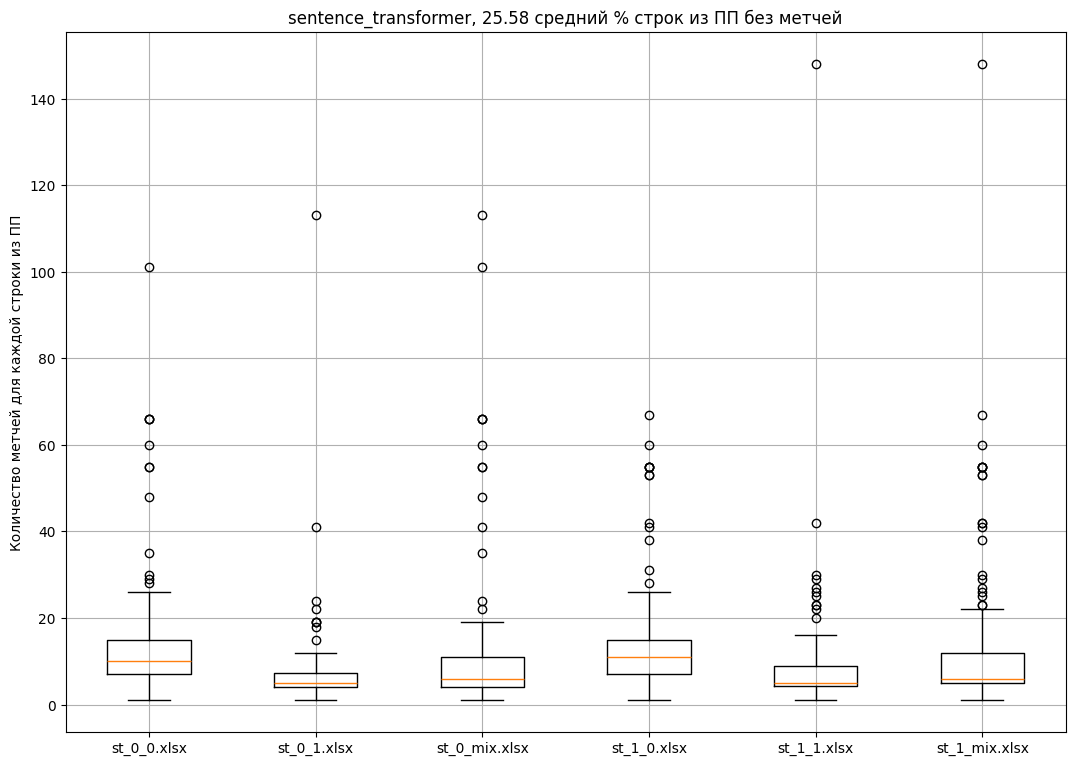

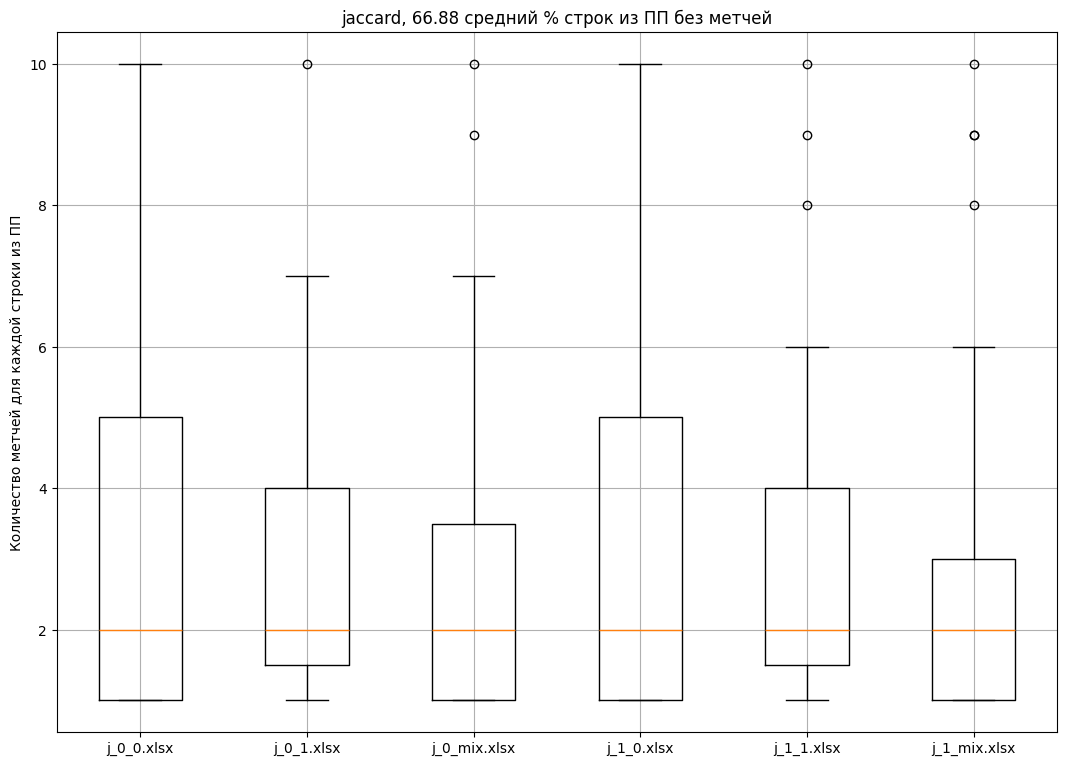

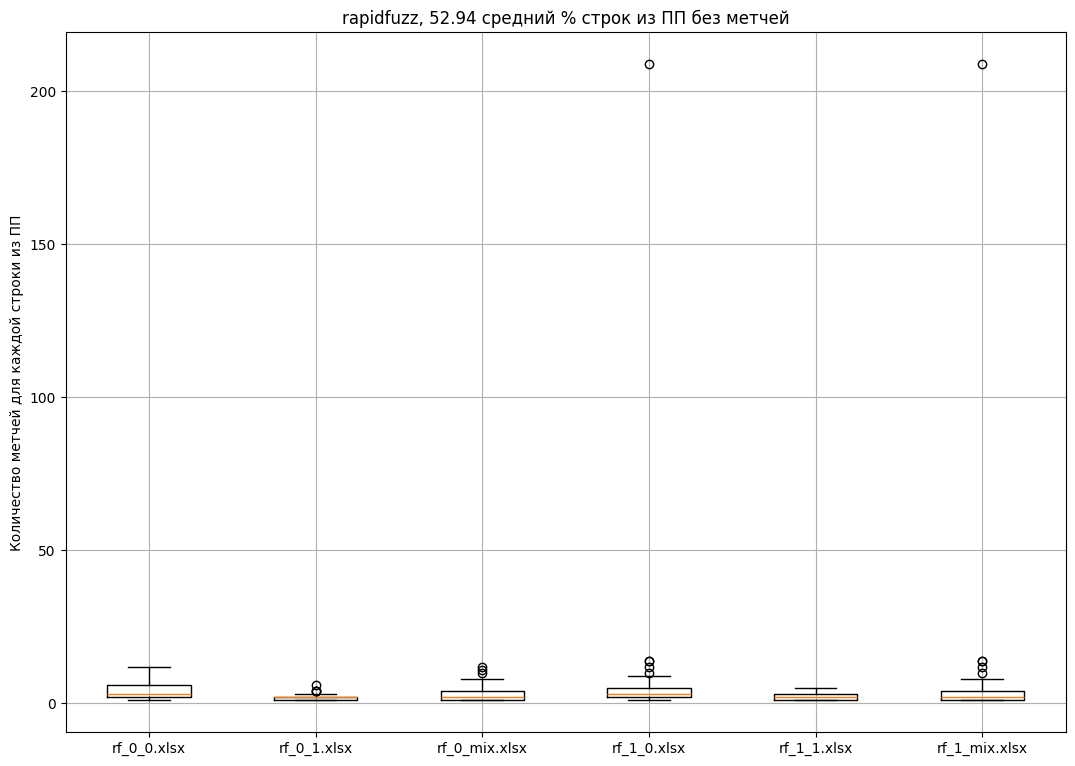

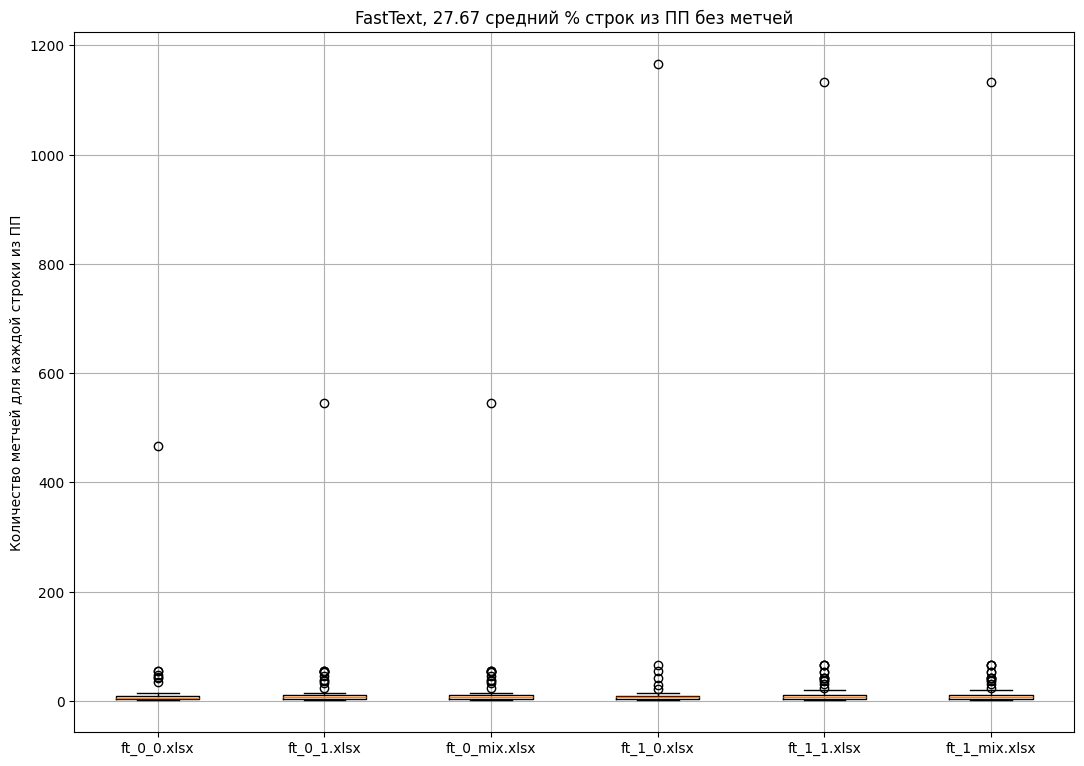

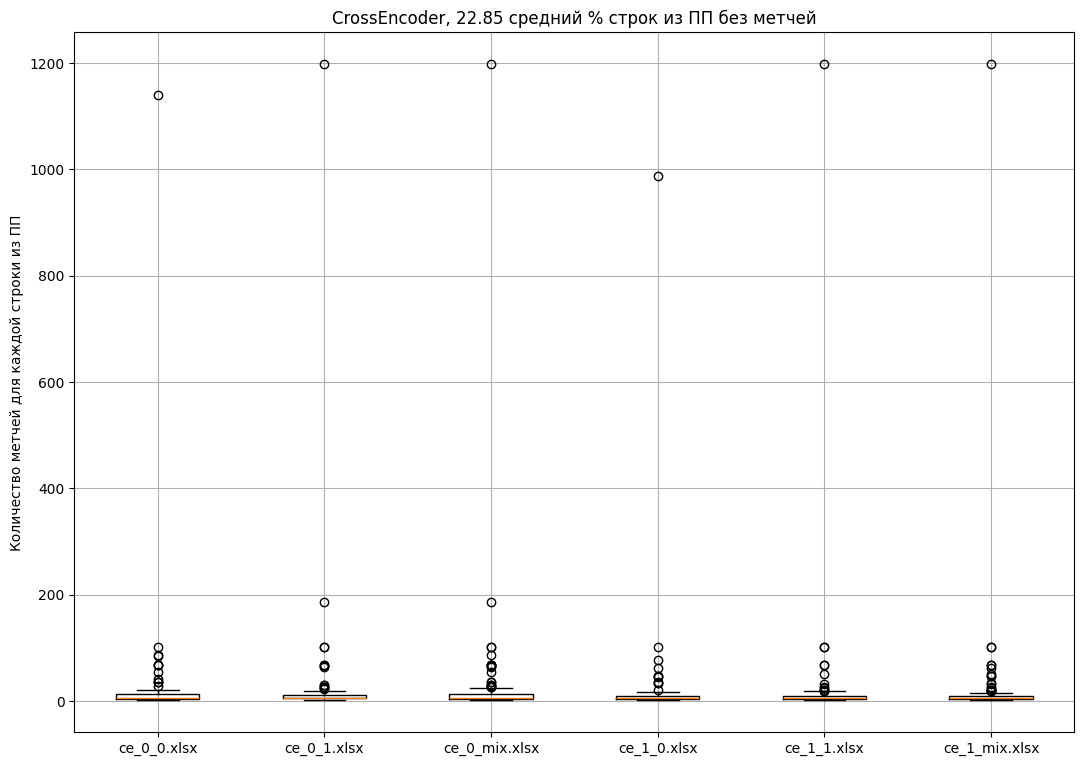

In [18]:
dir_path = "result_tables/sentence_transformer"
dfs_trans = data_process(dir_path)
count_analysis(dfs_trans, "sentence_transformer", os.listdir(dir_path))

dir_path = "result_tables/jaccard"
dfs_trans = data_process(dir_path)
count_analysis(dfs_trans, "jaccard", os.listdir(dir_path))

dir_path = "result_tables/rapidfuzz"
dfs_trans = data_process(dir_path)
count_analysis(dfs_trans, "rapidfuzz", os.listdir(dir_path))

dir_path = "result_tables/FastText"
dfs_trans = data_process(dir_path)
count_analysis(dfs_trans, "FastText", os.listdir(dir_path))

dir_path = "result_tables/CrossEncoder"
dfs_trans = data_process(dir_path)
count_analysis(dfs_trans, "CrossEncoder", os.listdir(dir_path))

In [19]:
def similarity(dfs, title, labels):
    datas = []
    nuls_p = 0
    for df in dfs:
        data = df["Схожесть"].tolist()
        datas.append(data)

    fig = plt.figure(figsize =(10, 7))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(datas, tick_labels = labels)
    ax.set_title(f"{title}")
    ax.set_ylabel('Схожесть')
    plt.grid()
    plt.show()

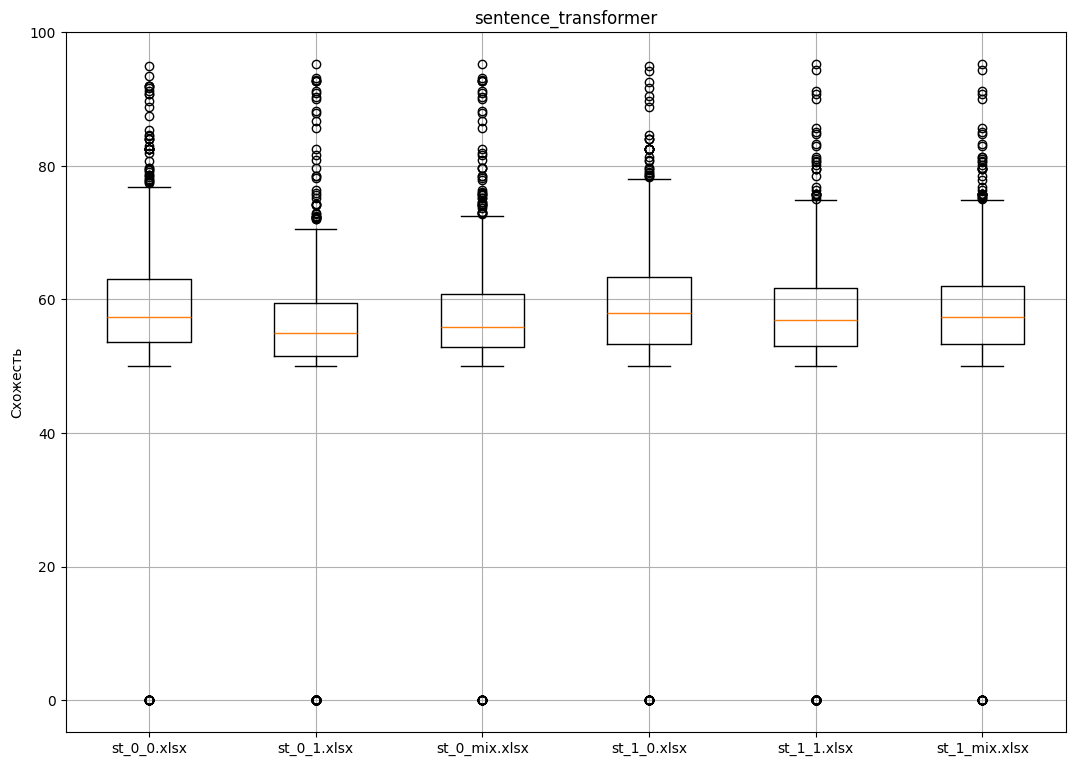

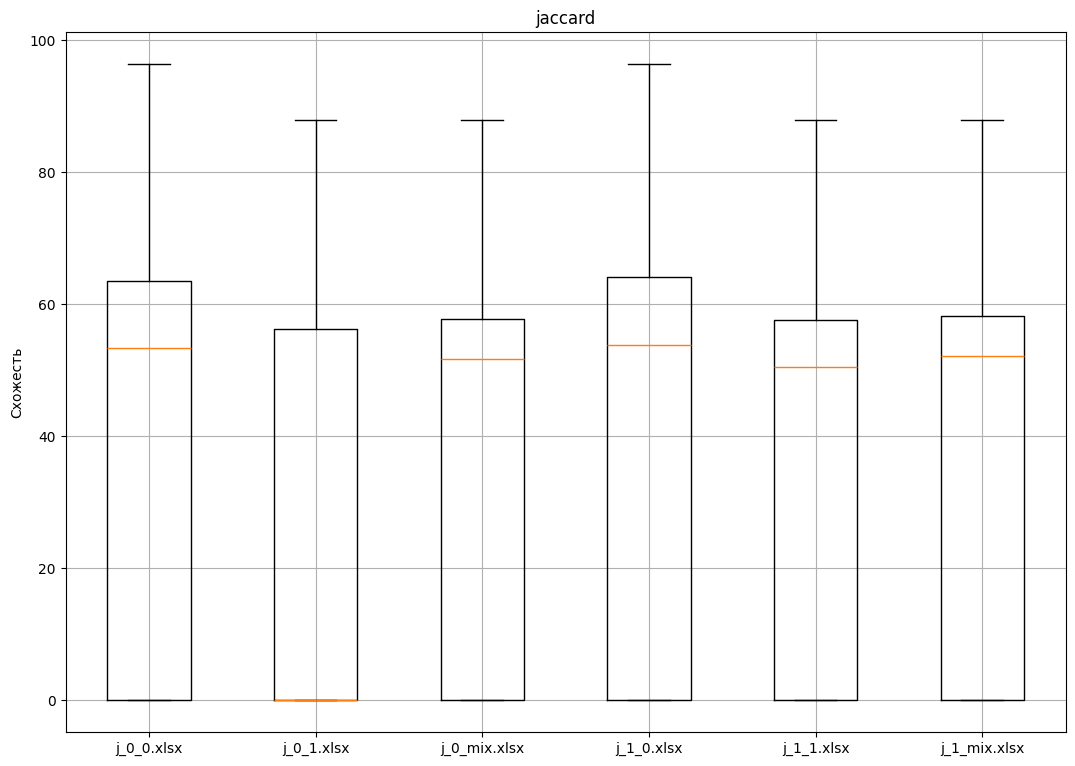

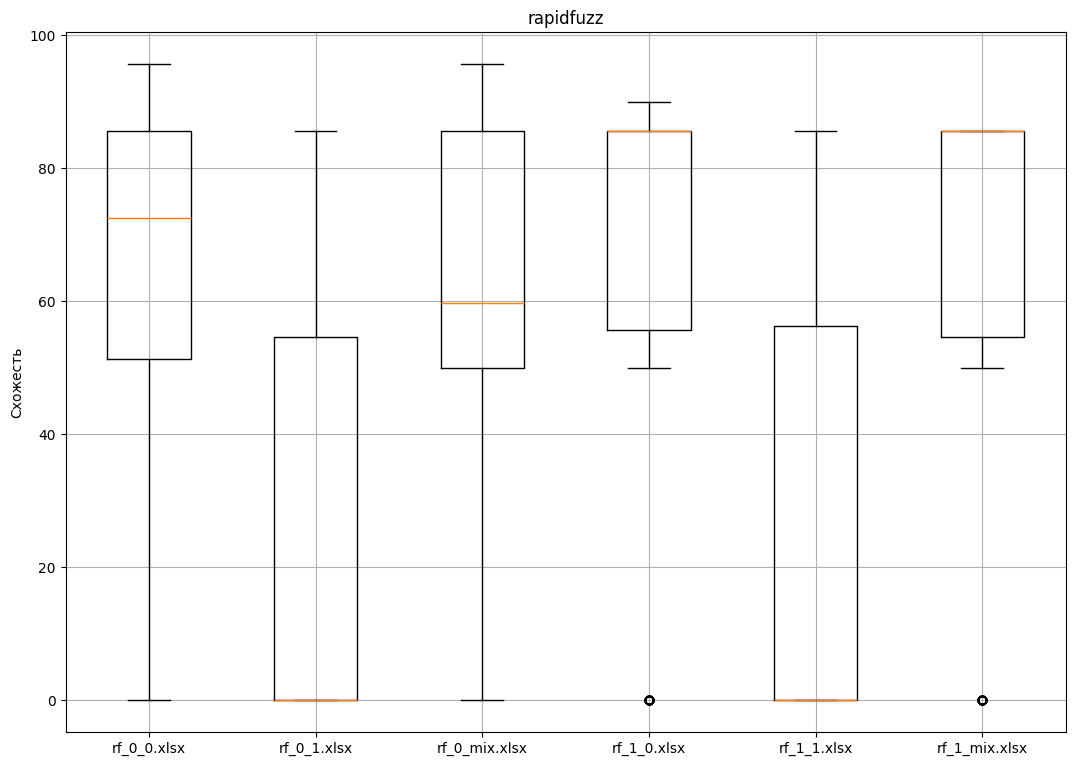

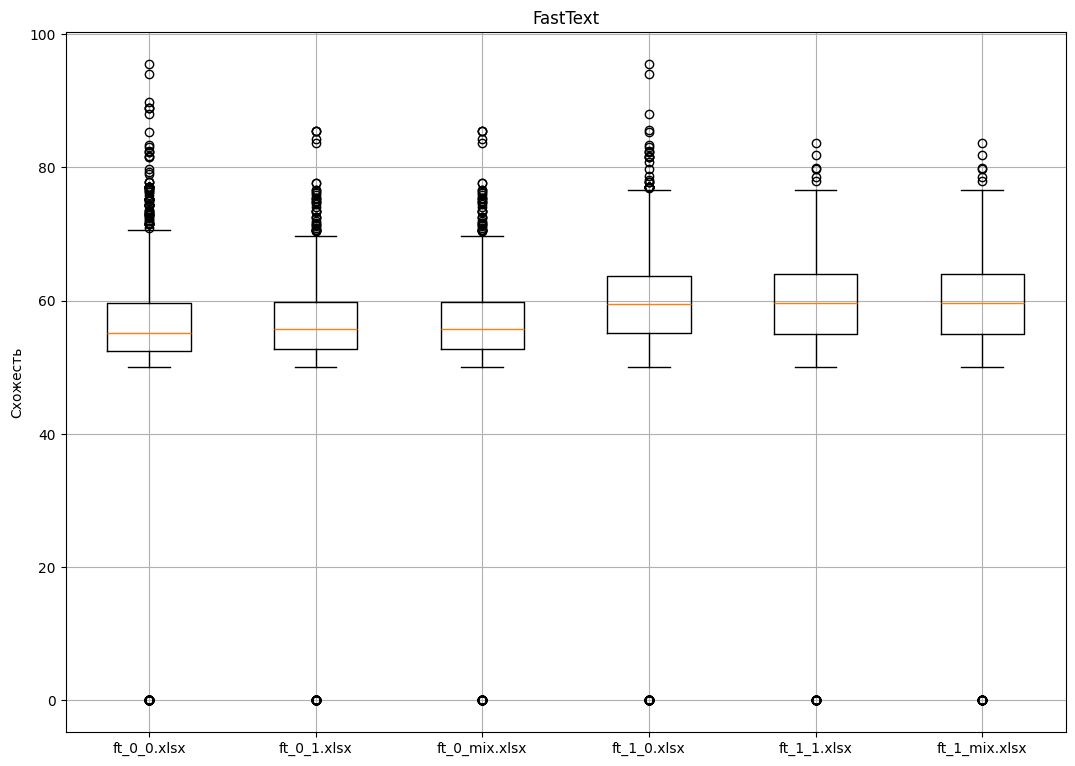

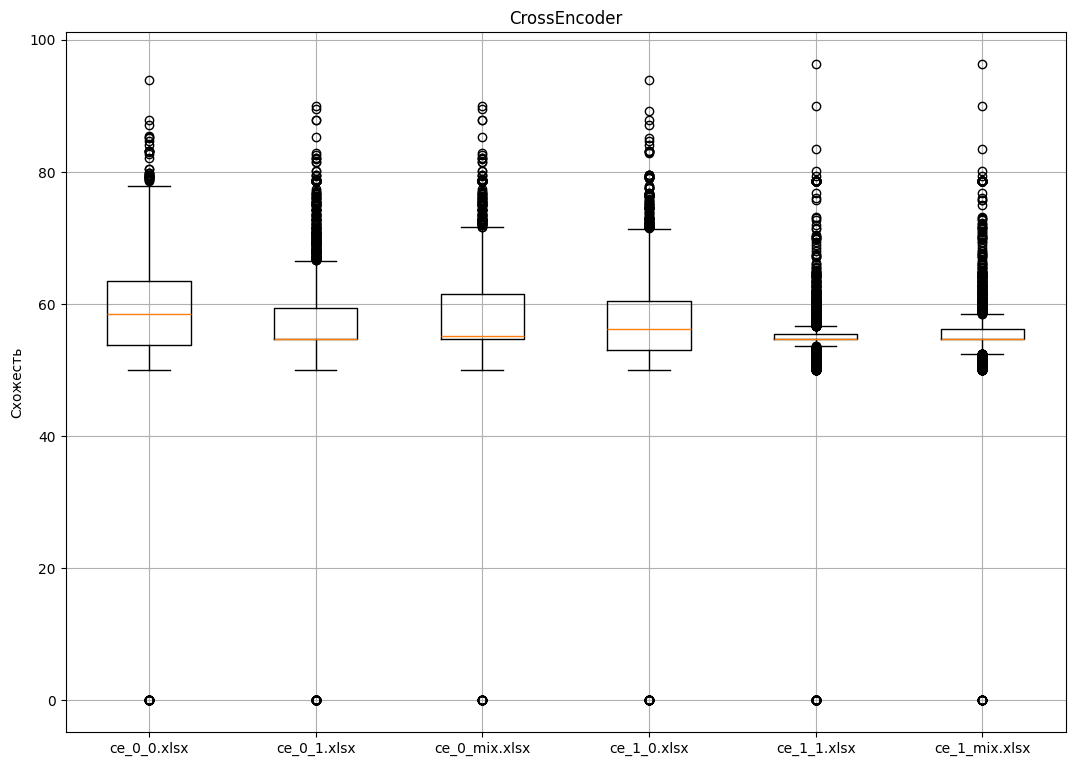

In [20]:
dir_path = "result_tables/sentence_transformer"
dfs_trans = data_process(dir_path)
similarity(dfs_trans, "sentence_transformer", os.listdir(dir_path))

dir_path = "result_tables/jaccard"
dfs_trans = data_process(dir_path)
similarity(dfs_trans, "jaccard", os.listdir(dir_path))

dir_path = "result_tables/rapidfuzz"
dfs_trans = data_process(dir_path)
similarity(dfs_trans, "rapidfuzz", os.listdir(dir_path))

dir_path = "result_tables/FastText"
dfs_trans = data_process(dir_path)
similarity(dfs_trans, "FastText", os.listdir(dir_path))

dir_path = "result_tables/CrossEncoder"
dfs_trans = data_process(dir_path)
similarity(dfs_trans, "CrossEncoder", os.listdir(dir_path))

## Проверка на эталонных данных

In [78]:
from math import log
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pivot_table = "../data/pivot_table.xlsx"
dfs = pd.read_excel(pivot_table, sheet_name=None)
dfs_pivot = dfs["Сводная ПП+Потребности"]

In [3]:
pp_headers = ['Потребитель', 'Отдел', 'Установка', 'Материал ПП', 'Товар', 'Производитель']
potrebnosti_headers = ['Потребитель', 'Материал потребитель', 'Отдел', 'Ответственный', ]

In [4]:
import math 
def prep_alg(dfs_alg):
    dfs_alg = dfs_alg[['Отдел', 'Потребитель', 'Установка', 'Материал, применение', 
                  'Товар', 'Производитель', 'Потребитель.1', 'Материал', 'Отдел.1', 'Ответственный','Схожесть']]
    return dfs_alg

def get_alg_matches(dfs_alg):
    # Список для хранения индексов
    index_groups = []

    # Временная переменная для хранения индексов текущей группы
    current_group = []

    # Временная переменная для хранения последнего ненулевого значения
    last_value = None

    # Проход по всем значениям в столбце
    for i, value in enumerate(dfs_alg["Отдел"]):
        if pd.notna(value):  # Если значение не NaN
            # Если текущая группа не пустая, добавляем её в общий список
            if current_group:
                index_groups.append(current_group)
            
            # Начинаем новую группу и обновляем последнее значение
            current_group = [i]
            last_value = value
        else:
            # Если NaN, добавляем индекс в текущую группу
            current_group.append(i)

    # Добавляем последнюю группу в список
    if current_group:
        index_groups.append(current_group)
    return index_groups

def fill_nan(dfs):
    dfs['Производитель'] = dfs['Производитель'].fillna(0)
    dfs['Товар'] = dfs['Товар'].fillna(0)
    dfs['Установка'] = dfs['Установка'].fillna(0)
    return dfs

def find_pp(dfs_alg, dfs_pivot, index_groups):
    match = []
    dfs_pivot = fill_nan(dfs_pivot)
    dfs_alg = fill_nan(dfs_alg)

    for group in index_groups:
        pp_row_ind = group[0]
        pp_row = dfs_alg.iloc[pp_row_ind][['Потребитель', 'Отдел', 'Установка', 'Материал, применение', 'Товар', 'Производитель']]
        matching_rows = dfs_pivot.loc[
        (pp_row['Потребитель'] == dfs_pivot['Потребитель']) &
        (dfs_pivot['Отдел'] == pp_row['Отдел']) &
        (dfs_pivot['Установка'] == pp_row['Установка'] ) &
        (dfs_pivot['Материал ПП'] == pp_row['Материал, применение']) &
        (dfs_pivot['Товар'] == pp_row['Товар'] ) &
        (dfs_pivot['Производитель'] == pp_row['Производитель']),
        ]
        
        matching_indices = matching_rows.index.tolist()
        
        match.append(matching_indices)
    return match

def calc_acc(dfs_alg, index_groups, match_pp):
    result = []
    match_potrebnosti = []
    zero_match = 0
    for m, ys in enumerate(match_pp):
        xs = index_groups[m]
        total = len(xs)
        for y in ys:
            yp=0
            true_val = dfs_pivot.iloc[y][potrebnosti_headers].tolist()
            for x in xs:
                pred_val = dfs_alg.iloc[x][['Потребитель.1', 'Материал', 'Отдел.1', 'Ответственный']].tolist()
                if pred_val == true_val and pd.notna(dfs_alg.iloc[x]["Схожесть"]):
                    yp+=dfs_alg.iloc[x]["Схожесть"]/100
                elif not pd.notna(dfs_alg.iloc[x]["Схожесть"]) and not pd.notna(dfs_pivot.iloc[y]["Материал потребитель"]):
                    yp = 1
                else:
                    yp = 0
                if not pd.notna(dfs_alg.iloc[x]["Схожесть"]) and pd.notna(dfs_pivot.iloc[y]["Материал потребитель"]):
                    zero_match+=1
            #if math.isnan(yp/total):
            #    result.append(0)
            #else:
            result.append(yp/total)
            if yp/total!=0:
                match_potrebnosti.append(y)
    return result, match_potrebnosti, zero_match

In [5]:
def eval_alg(dfs_alg, dfs_pivot):
    dfs_alg = prep_alg(dfs_alg)
    index_groups = get_alg_matches(dfs_alg)
    match_pp = find_pp(dfs_alg, dfs_pivot, index_groups)
    result, match_potrebnosti, zero_match = calc_acc(dfs_alg, index_groups, match_pp)
    return result, match_potrebnosti, zero_match

In [ ]:
import os 
algs = os.listdir("../result_tables/mix")
results = []
matches = []
zero_matches = []
for alg_name in algs:
    k = 0
    alg_name = "../result_tables/mix/" + alg_name
    dfs_alg = pd.read_excel(alg_name, sheet_name=None)['Sheet']
    result, match_potreb, zero_match = eval_alg(dfs_alg, dfs_pivot)
    results.append(result)
    matches.append(match_potreb)
    zero_matches.append(zero_match)

In [7]:
import numpy as np
for i in range(len(algs)):
    print(f'{algs[i]}: {np.count_nonzero(np.array(results[i]))} совпадений из {len(dfs_alg["Отдел"].dropna())}, {np.count_nonzero(np.array(results[i]))*100/len(dfs_alg["Отдел"].dropna())}%')

ce_0_0.xlsx: 19 совпадений из 159, 11.949685534591195%
ft_0_0.xlsx: 35 совпадений из 159, 22.0125786163522%
j_0_0.xlsx: 66 совпадений из 159, 41.509433962264154%
rf_0_0.xlsx: 43 совпадений из 159, 27.044025157232703%
st_0_0.xlsx: 16 совпадений из 159, 10.062893081761006%


In [8]:
for i, y in enumerate(matches):
    print(f"Не пустые соответсвия, {algs[i]}: {sum(pd.notna(dfs_pivot.iloc[y]["Материал потребитель"]).tolist())}, Нет найденных совпадений при условии их существования: {zero_matches[i]}")

Не пустые соответсвия, ce_0_0.xlsx: 1, Нет найденных совпадений при условии их существования: 12
Не пустые соответсвия, ft_0_0.xlsx: 3, Нет найденных совпадений при условии их существования: 24
Не пустые соответсвия, j_0_0.xlsx: 5, Нет найденных совпадений при условии их существования: 43
Не пустые соответсвия, rf_0_0.xlsx: 5, Нет найденных совпадений при условии их существования: 39
Не пустые соответсвия, st_0_0.xlsx: 1, Нет найденных совпадений при условии их существования: 11


p_i/N

<Figure size 1000x600 with 0 Axes>

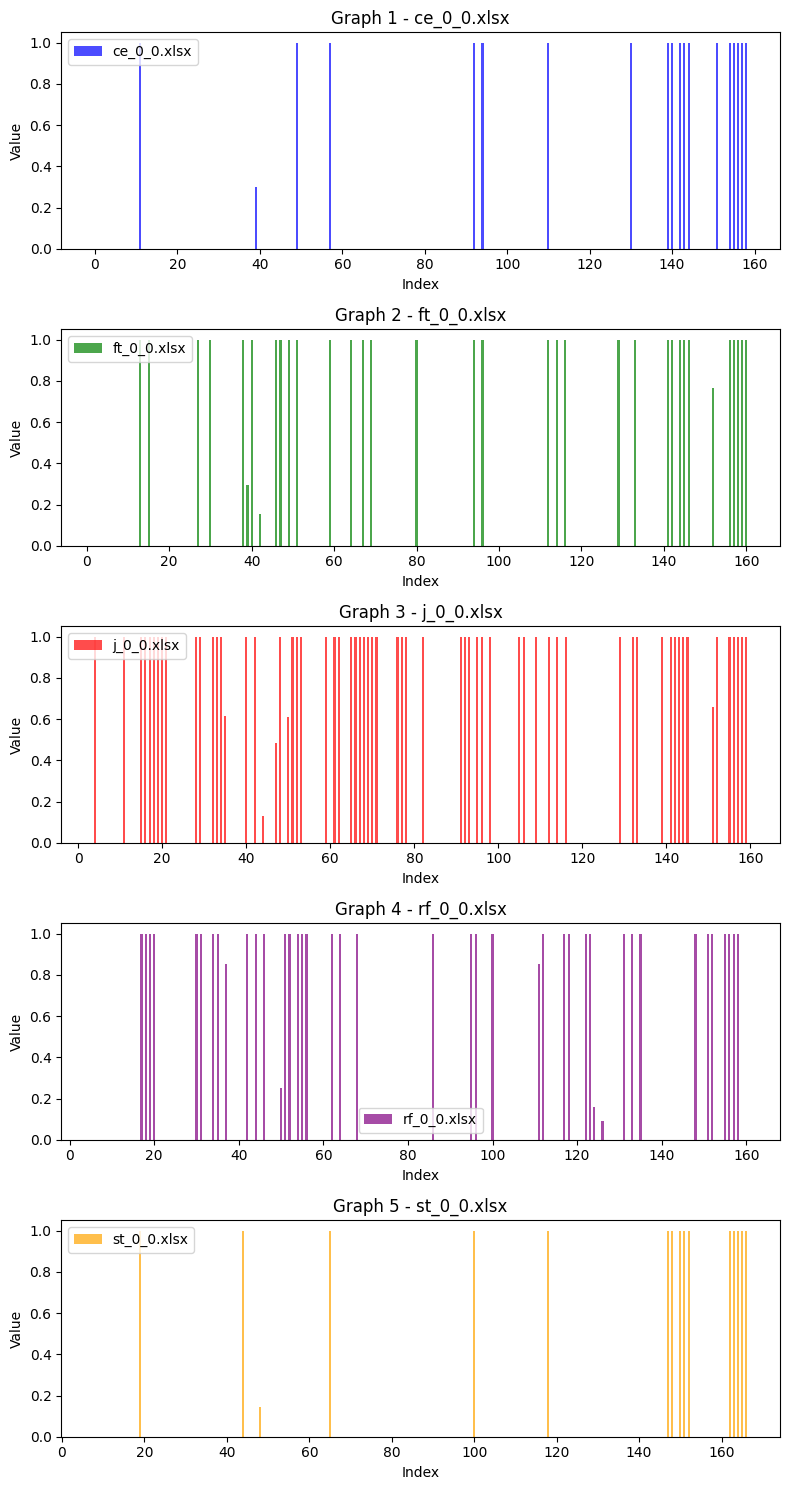

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Создаем фигуру и набор осей с 5 графиками (5 строк, 1 столбец)
fig, axes = plt.subplots(5, 1, figsize=(8, 15))  # 5 строк и 1 столбец

# Цикл для построения каждого графика на своей оси
for i in range(len(results)):
    n_values = len(results[i])
    x = np.arange(n_values) + i * 2  # Сдвиг данных для разделения гистограмм
    axes[i].bar(x, results[i], width=0.5, label=algs[i], alpha=0.7, color = colors[i])
    axes[i].set_title(f'Graph {i + 1} - {algs[i]}')    # Название каждого графика
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()  # Легенда для каждого графика
    

# Оставляем пространство между графиками
plt.tight_layout()

# Показываем все графики
plt.show()



In [38]:
dfs_pivot_original = dfs_pivot.copy()
dfs_pivot = data_preprocess_pivot(dfs_pivot.copy())
dfs_pivot = data_preprocess_pivot_dops(dfs_pivot.copy())

In [39]:
dfs_pivot = dfs_pivot.dropna(subset = ["Материал потребитель"])

In [46]:
dfs_pivot = dfs_pivot.reset_index()

In [67]:
dfs_pivot["схожесть"] = 0

In [ ]:
for i in range(dfs_pivot.shape[0]):
    param = dfs_pivot.loc[i][["Материал ПП", "Товар", "Установка", "Производитель"]].tolist()
    param = ' '.join(np.array(param).astype(str))
    resalt, indx_res = param_sort_ce(param=param, table=dfs_pivot.loc[i],column_name=["Материал потребитель", "Примечание"], 
                                    original_table=dfs_pivot_original, threshold=0, similarity=True)
    print(resalt["схожесть"])
    dfs_pivot.loc[i, "схожесть"] = resalt["схожесть"]

In [75]:
dfs_pivot["схожесть"]

0     79.119148
1     68.756310
2     49.886806
3     65.233597
4     37.693874
        ...    
95    59.288364
96    52.904797
97    59.250336
98    63.942356
99    50.548027
Name: схожесть, Length: 100, dtype: float64

In [76]:
dfs_pivot.to_excel('ce_pivot_dropna.xlsx', index=False)

In [270]:
pivot_table = "ce_pivot.xlsx"
dfs = pd.read_excel(pivot_table, sheet_name=None)
datas = dfs["Sheet1"]["схожесть"].tolist()

<Figure size 1000x700 with 0 Axes>

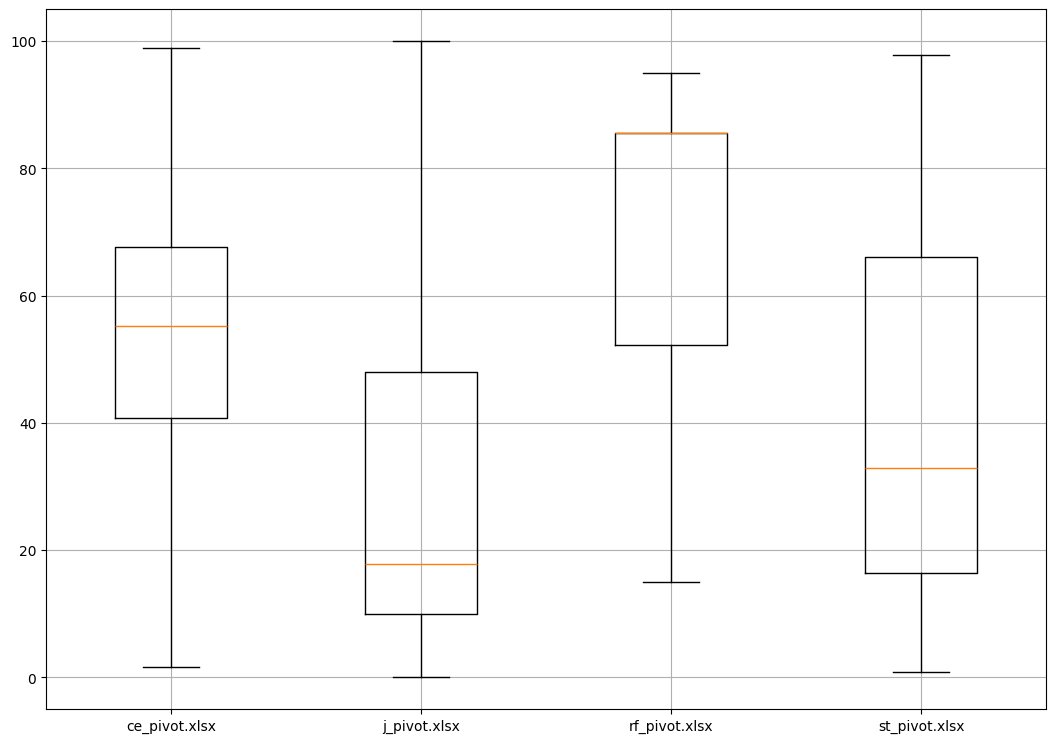

In [286]:
pivot_tables = ["ce_pivot.xlsx", "j_pivot.xlsx", "rf_pivot.xlsx", "st_pivot.xlsx"]
fig = plt.figure(figsize =(10, 7))
datas = []
for pivot_table in pivot_tables:
    dfs = pd.read_excel(pivot_table, sheet_name=None)
    data = dfs["Sheet1"]["схожесть"].tolist()
    datas.append(data)
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(datas, tick_labels=pivot_tables)
plt.grid()
plt.show()

In [300]:
for i, pivot_table in enumerate(pivot_tables):
    data = np.array(datas[i])
    print(f"Число строк со схожестью больше 50 из {len(datas[i])}: {len(data[data>50])} {pivot_table}")

Число строк со схожестью больше 50 из 277: 167 ce_pivot.xlsx
Число строк со схожестью больше 50 из 277: 59 j_pivot.xlsx
Число строк со схожестью больше 50 из 277: 209 rf_pivot.xlsx
Число строк со схожестью больше 50 из 277: 97 st_pivot.xlsx


<Figure size 1000x700 with 0 Axes>

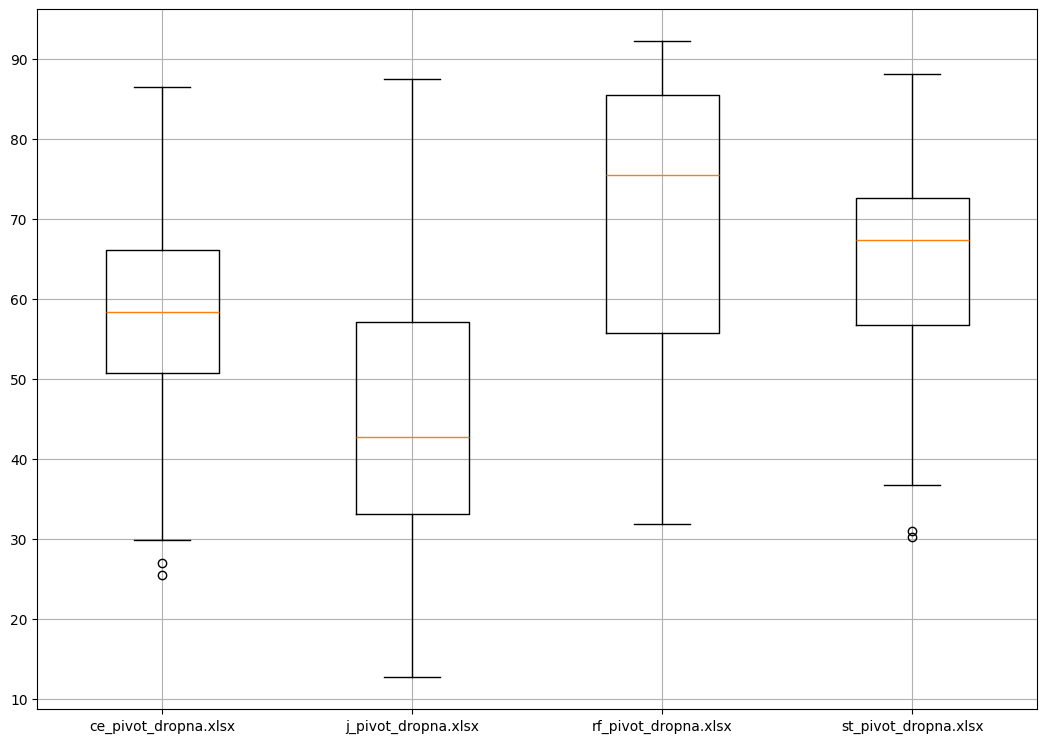

In [79]:
pivot_tables = ["ce_pivot_dropna.xlsx", "j_pivot_dropna.xlsx", "rf_pivot_dropna.xlsx", "st_pivot_dropna.xlsx"]
fig = plt.figure(figsize =(10, 7))
datas = []
for pivot_table in pivot_tables:
    dfs = pd.read_excel(pivot_table, sheet_name=None)
    data = dfs["Sheet1"]["схожесть"].tolist()
    datas.append(data)
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(datas, tick_labels=pivot_tables)
plt.grid()
plt.show()

In [86]:

for i, pivot_table in enumerate(pivot_tables):
    data = np.array(datas[i])
    print(f"Число строк со схожестью больше 50 из {len(datas[i])}: {len(data[data>50])} {pivot_table}")

Число строк со схожестью больше 50 из 100: 78 ce_pivot_dropna.xlsx
Число строк со схожестью больше 50 из 100: 36 j_pivot_dropna.xlsx
Число строк со схожестью больше 50 из 100: 81 rf_pivot_dropna.xlsx
Число строк со схожестью больше 50 из 100: 87 st_pivot_dropna.xlsx


## pretrained Bert model on pivot data

In [14]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert_finetuned/tokenizer")
model_original = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
model_trained = torch.load('bert_finetuned/3_epochs_bert.pth')


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_7927/1646921697.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the c

In [15]:
model = model_trained.to('cpu')
# Функция для получения эмбеддингов BERT
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Используем выходы CLS-токена в качестве эмбеддингов
    return outputs.last_hidden_state[:, 0, :].numpy()

# Функция для вычисления косинусной схожести
def calculate_cosine_similarity(df):
    similarities = []
    
    for idx, row in df.iterrows():
        text1 = row[0]  # Первая строка
        text2 = row[1]  # Вторая строка
        
        # Получаем эмбеддинги для каждой строки
        embedding1 = get_bert_embedding(text1)
        embedding2 = get_bert_embedding(text2)
        
        # Рассчитываем косинусную схожесть между строками
        similarity = cosine_similarity(embedding1, embedding2)
        similarities.append(similarity[0][0])  # Добавляем в массив
    
    return np.array(similarities)

In [3]:
pivot_table = "../data/pivot_table.xlsx"
dfs = pd.read_excel(pivot_table, sheet_name=None)
dfs_pivot = dfs["Сводная ПП+Потребности"]
dfs_pivot = data_preprocess_pivot(dfs_pivot.copy())
dfs_pivot = data_preprocess_pivot_dops(dfs_pivot.copy())
dfs_pivot = dfs_pivot.dropna(subset = ["Материал потребитель"])
dfs_pivot = dfs_pivot.reset_index()
df = dfs_pivot[['Материал ПП', 'Материал потребитель']]

NameError: name 'data_preprocess_pivot' is not defined

In [3]:
pivot_table = "../data/pivot_table.xlsx"
dfs = pd.read_excel(pivot_table, sheet_name=None)
dfs_pivot = dfs["Сводная ПП+Потребности"]
df = dfs_pivot[['Материал ПП', 'Материал потребитель']]

In [17]:
data = {'text1': ["ЯНОС"],
        'text2': ["кошка"]}
df = pd.DataFrame(data)

similarities = calculate_cosine_similarity(df)

# Выводим результат
print(similarities)

[0.89841497]


/tmp/ipykernel_7927/878505898.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text1 = row[0]  # Первая строка
/tmp/ipykernel_7927/878505898.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text2 = row[1]  # Вторая строка


In [22]:
similarities = np.array(similarities)
sum(similarities>0.9)

100

In [26]:
df.loc[96]

Материал ПП                                антифоулянт
Материал потребитель    ингибитор антикоксообразовател
Name: 96, dtype: object